### Predição K50 - train_test_review - features light reduction

### Bibliotecas

In [167]:
from functools import partial
from glob import glob
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [168]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler 

In [169]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Função pronta

Abaixo temos um bloco de função que você pode apenas copiar e colar no seu codigo, e usa-lo para obter os dados de uma doença

In [170]:
# Importando bases

df_doenca_agg = pd.read_csv(r'dados_com-clima_doenca_agrupado.csv', sep=';', dtype='str', low_memory=False)
df_doenca_agg['cod_muni'] = df_doenca_agg['cod_muni'].astype('int')
df_doenca_agg['ano'] = df_doenca_agg['ano'].astype('int')
df_doenca_agg['prevalencia'] = df_doenca_agg['prevalencia'].astype('float')
df_doenca_agg.set_index(['cod_muni', 'doenca', 'ano', 'estacao'], inplace=True)

df_doenca_dgg = pd.read_csv(r'dados_com-clima_doenca_desagrupado.csv', sep=';', dtype='str', low_memory=False)
df_doenca_dgg['cod_muni'] = df_doenca_dgg['cod_muni'].astype('int')
df_doenca_dgg['ano'] = df_doenca_dgg['ano'].astype('int')
df_doenca_dgg['prevalencia'] = df_doenca_dgg['prevalencia'].astype('float')
df_doenca_dgg.set_index(['cod_muni', 'doenca', 'ano', 'estacao'], inplace=True)

df_doenca_agg_mes = pd.read_csv(r'dados_com-clima_doenca_agrupado_agg_mes.csv', sep=';', dtype='str', low_memory=False)
df_doenca_agg_mes['cod_muni'] = df_doenca_agg_mes['cod_muni'].astype('int')
df_doenca_agg_mes['ano'] = df_doenca_agg_mes['ano'].astype('int')
df_doenca_agg_mes['mes'] = df_doenca_agg_mes['mes'].astype('int')
df_doenca_agg_mes['prevalencia'] = df_doenca_agg_mes['prevalencia'].astype('float')
df_doenca_agg_mes.set_index(['cod_muni', 'doenca', 'ano', 'mes'], inplace=True)

df_doenca_dgg_mes = pd.read_csv(r'dados_com-clima_doenca_desagrupado_agg_mes.csv', sep=';', dtype='str', low_memory=False)
df_doenca_dgg_mes['cod_muni'] = df_doenca_dgg_mes['cod_muni'].astype('int')
df_doenca_dgg_mes['ano'] = df_doenca_dgg_mes['ano'].astype('int')
df_doenca_dgg_mes['mes'] = df_doenca_dgg_mes['mes'].astype('int')
df_doenca_dgg_mes['prevalencia'] = df_doenca_dgg_mes['prevalencia'].astype('float')
df_doenca_dgg_mes.set_index(['cod_muni', 'doenca', 'ano', 'mes'], inplace=True)

df_clima = pd.read_csv(r'dados_com-clima_clima.csv', sep=';', 
                       index_col=['cod_muni', 'ano', 'estacao'], low_memory=False)

df_clima_mes = pd.read_csv(r'dados_com-clima_clima_agg_mes.csv', sep=';', 
                       index_col=['cod_muni', 'ano', 'mes'], low_memory=False)

df_censo_cs = pd.read_csv(r'dados_com-clima_censo_com_selecao.csv', sep=';', 
                       index_col=['cod_muni'], low_memory=False)

df_censo_ss = pd.read_csv(r'dados_com-clima_censo_sem_selecao.csv', sep=';', 
                       index_col=['cod_muni'], low_memory=False)

def pega_dados(agrupado=True, selecao=True, doenca=None, ano=None, estacao=None, por_mes=False, mes=None):
    '''
    Parametros
    - agrupado: se deve ou não pegar doencas com CID agrupado
    - selecao: se deve ou não pegar dados do Censo com selecao de colunas
    - doenca: se especificado pega somente entradas daquela doença
    - ano: se especificado pega somente as entradas daquele ano
    - estacao: se especificado pega somente entradas daquela estacao
    - por_mes: se deve ou não agrupar os dados por mes, ao inves de clima
    - mes: se especificado pega somente as entradas daquele mes

    Os argumentos 'doenca', 'ano', 'estacao' e 'mes' podem tanto receber um só valor assim 
    como um lista de valores para serem selecionados.

    Retorna 2 dataframes, x e y, com dados de entrada e saida
    '''

    if estacao and por_mes:
        print('ERRO: não é possivel especificar uma estação agrupando por mes')
        return
    if estacao and mes: 
        print('ERRO: não é possivel especificar uma estação e um mes')
        return

    # tratando os parametros
    if por_mes:
        if agrupado:
            df_total = df_doenca_agg_mes.copy()
        else:
            df_total = df_doenca_dgg_mes.copy()
    else:
        if agrupado:
            df_total = df_doenca_agg.copy()
        else:
            df_total = df_doenca_dgg.copy()

    # não precisamos de index pra fazer os merges
    df_total.reset_index(inplace=True)

    if doenca: 
        if type(doenca) is not list: doenca = [doenca]
        df_total = df_total[df_total['doenca'].isin(doenca)]
    if ano: 
        if type(ano) is not list: ano = [ano]
        df_total = df_total[df_total['ano'].isin(ano)]
    if estacao: 
        if type(estacao) is not list: estacao = [estacao]
        df_total = df_total[df_total['estacao'].isin(estacao)]
    if mes:
        if type(mes) is not list: mes = [mes]
        df_total = df_total[df_total['mes'].isin(mes)]

    if por_mes:
        df_total = pd.merge(df_total, df_clima_mes, on=['cod_muni', 'ano', 'mes'])    
    else:
        df_total = pd.merge(df_total, df_clima, on=['cod_muni', 'ano', 'estacao']) 

    if selecao:
        df_total = pd.merge(df_total, df_censo_cs, on=['cod_muni'])
    else:
        df_total = pd.merge(df_total, df_censo_ss, on=['cod_muni'])

    if por_mes:
        df_total.set_index(['cod_muni', 'doenca', 'ano', 'mes'], inplace=True)
    else:
        df_total.set_index(['cod_muni', 'doenca', 'ano', 'estacao'], inplace=True)

    df_total.dropna(inplace=True)
    # separando dataframe
    y = df_total[['prevalencia']]
    x = df_total.drop(columns=['prevalencia'])
    
    del df_total
    return x, y

## K50 - Doença de Crohn

In [171]:
xi, yi= pega_dados(agrupado=True, doenca='K50', ano=[2011,2010,2013,2014]) # Dados_treino
xo, yo= pega_dados(agrupado=True, doenca='K50', ano=[2012]) # Dados_teste
# x2010 = 363 casos
# x2011 = 380 casos
# x2012 = 362 casos
# x2013 = 419 casos
# x2014 = 415 casos
# conjunto treino = 380+363+419+415 = 1577
# conjunto teste = 362- 2012 (menor quantidade)

In [172]:
xi.head(2)

temp_media  temp_maxima  temp_minima  \
cod_muni doenca ano  estacao                                         
290100   K50    2013 O            23.546         35.5         17.9   
290160   K50    2010 P            24.936         35.7         16.3   

                              umidade_relativa  umidade_relativa_maxima  \
cod_muni doenca ano  estacao                                              
290100   K50    2013 O                  78.899                     95.0   
290160   K50    2010 P                  71.762                     96.0   

                              umidade_relativa_minima  precipitacao_media  \
cod_muni doenca ano  estacao                                                
290100   K50    2013 O                           30.0               0.072   
290160   K50    2010 P                           14.0               0.067   

                              precipitacao_max  precipitacao_min  \
cod_muni doenca ano  estacao                                       
290100   K50    2013 O                    11.4               0.0   
290160   K50    2010 P                    55.0               0.0   

                              pressao_atm_med  ...  V032_domicilio02  \
cod_muni doenca ano  estacao                   ...                     
290100   K50    2013 O                970.816  ...          0.287444   
290160   K50    2010 P                970.305  ...          0.157685   

                              V033_domicilio02  V034_domicilio02  \
cod_muni doenca ano  estacao                                       
290100   K50    2013 O                0.199557          0.011266   
290160   K50    2010 P                0.178948          0.009665   

                              V035_domicilio02  V036_domicilio02  \
cod_muni doenca ano  estacao                                       
290100   K50    2013 O                0.057844          0.000699   
290160   K50    2010 P                0.100633          0.000469   

                              V037_domicilio02  V038_domicilio02  \
cod_muni doenca ano  estacao                                       
290100   K50    2013 O                0.014061          0.964630   
290160   K50    2010 P                0.023606          0.906455   

                              V041_domicilio02  V045_domicilio02  \
cod_muni doenca ano  estacao                                       
290100   K50    2013 O                0.031819          0.484615   
290160   K50    2010 P                0.086340          0.502636   

                              V089_domicilio02  
cod_muni doenca ano  estacao                    
290100   K50    2013 O                0.515385  
290160   K50    2010 P                0.497364  

[2 rows x 96 columns]

In [173]:
yg = yo

In [174]:
xg = xo

### Criação da coluna variação de temperatura

In [9]:
xi['Temp_var']= xi['temp_maxima']-xi['temp_minima']
xo['Temp_var']= xo['temp_maxima']-xo['temp_minima']

### Preparação Dados - Extração de atributos 

In [10]:
xi = xi.drop(columns = ['temp_maxima','temp_minima','umidade_relativa_maxima','umidade_relativa_minima','precipitacao_media',
'precipitacao_max','precipitacao_min','pressao_atm_med','pressao_atm_max','pressao_atm_min',
'radiacao_max','radiacao_min','velocidade_vento_media','velocidade_vento_max','velocidade_vento_min'])

In [11]:
xo = xo.drop(columns = ['temp_maxima','temp_minima','umidade_relativa_maxima','umidade_relativa_minima','precipitacao_media',
'precipitacao_max','precipitacao_min','pressao_atm_med','pressao_atm_max','pressao_atm_min',
'radiacao_max','radiacao_min','velocidade_vento_media','velocidade_vento_max','velocidade_vento_min'])

### Análise_inicial_Features_Importance

In [18]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=100)
model.fit(xi, yi)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

([<matplotlib.axis.XTick at 0x266cf421a48>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

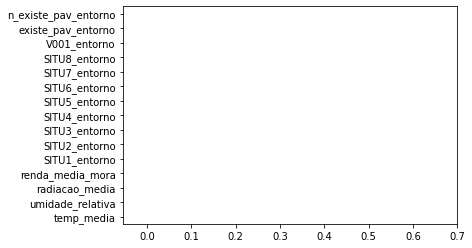

In [21]:
(pd.Series(model.feature_importances_, index=xi.columns)
   .nlargest(15).sort_values().plot.barh())
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]) 

### padronização dos dados 

In [22]:
sc = StandardScaler() 
sc.fit(xi)
xi = sc.transform(xi) 
xo = sc.transform(xo)
sc.fit(yi)
yi= sc.transform(yi)
yo= sc.transform(yo)

In [23]:
xi.shape

(1577, 82)

In [24]:
xo.shape

(362, 82)

In [25]:
a=np.mean(yi) #teste média y_train
a
a = [a]*len(yo)

### Predição_Algoritmos de Árvores

In [26]:
# Random_Forest_baseline
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [27]:
params_grid= {'n_estimators':[2,3,4,5,6,7,8,9,10],
              "max_features":['auto'],
              'max_depth':[1,3,5,10,20,30],
              'max_leaf_nodes':[2,3,4,5,6,7,8],
              'min_samples_leaf':[2,3,5,7,8,9,10,15],
              'min_samples_split':[3,6,9,12,15,18,21]}
random_rf = RandomizedSearchCV(estimator = rf,cv=10,param_distributions=params_grid,n_iter=100,verbose=2,n_jobs=-1)
random_rf.fit(xi, yi) #dados treino

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   29.6s finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_st...


In [28]:
random_rf.best_params_ # melhores parâmetros para serem usados

{'n_estimators': 9,
 'min_samples_split': 21,
 'min_samples_leaf': 8,
 'max_leaf_nodes': 8,
 'max_features': 'auto',
 'max_depth': 10}

In [29]:
# uso dos parãmetros indicados
m_rf=RandomForestRegressor(n_estimators= 9,
 min_samples_split = 21,
 min_samples_leaf = 8,
 max_leaf_nodes = 8,
 max_features ='auto',
 max_depth = 10)

In [30]:
yrf = m_rf.fit(xi,yi)
print(yrf)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=8,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=21,
                      min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)


In [31]:
y_rf= yrf.predict(xo)

In [33]:
mse_rf = round(mean_squared_error(yo, y_rf),4)
print(mse_rf)

0.1075


In [37]:
b = mean_squared_error(y_rf, a)
rrf = mse_rf/b
rrf = round(rrf,4)
rrf
# se r maior que 1.0, modelo pior que modelo simples (media y_train)

0.3749

### Algoritmos_Boosting

### Otimização_parâmetros

In [38]:
# Light & XG Boosting
params= {
    'booster': ["gbtree","gblinear",'dart'],
    'learning rate': [0.001, 0.01, 0.04, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1, 1.5],
    'max depth': [3,4,5,8,10,11,12],
    'min_child_weigth': [1,3,5,7,9],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3,0.4,0.5,0.6]
}

In [39]:
# Gradient Boosting
params0= {
    'min_samples_split': [200, 300,400,500],
    'min_samples_leaf': [10, 20, 30,40,50],
    'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [4,5,6,7,8],
    'subsample': [0.6,0.7,0.8],
    'learning_rate' : [0.001, 0.01, 0.04, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1, 1.5]
}

In [40]:
# Adaptative Boosting
params1= {
    'n_estimators': [30,40,50],
    'learning_rate' : [0.001, 0.01, 0.04, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1, 1.5]
}

### Regressores_definicao

In [41]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(xi, yi)
# Light Gradient Boosting
import lightgbm as lgb
lgb = lgb.LGBMRegressor(learning_rate = 0.001, 
                              num_leaves = 65,  
                              n_estimators = 100)                       
lgb.fit(xi, yi)
# XGBoost
import xgboost as xgb
xgb= xgb.XGBRegressor(learning_rate=0.001,
                            max_depth = 1, 
                            n_estimators = 100)
xgb.fit(xi,yi)
# AdaBoost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
ada = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=1), n_estimators=100,
    learning_rate=0.001)
ada.fit(xi, yi)

print('**Definicao_Classificadores**')

**Definicao_Classificadores**


In [42]:
# Random Search & Cross Validation
random_search_gbr = RandomizedSearchCV(gbr,param_distributions=params0,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_lgb = RandomizedSearchCV(lgb,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_xgb = RandomizedSearchCV(xgb,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_ada = RandomizedSearchCV(ada,param_distributions=params1,n_iter=5,n_jobs=-1,cv=5,verbose=3)

In [43]:
random_search_gbr.fit(xi, yi)
random_search_lgb.fit(xi, yi)
random_search_xgb.fit(xi, yi)
random_search_ada.fit(xi, yi)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    7.8s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    9.0s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    7.8s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   10.0s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    3.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   12.6s finished


[12:24:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { learning rate, max depth, min_child_weigth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    4.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    5.2s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                                                    max_depth=1,
                                                                                    max_features=None,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=1,
                                                                                    min_samples_split=2,
                                                                                    min_weight_fraction_lea

### Gradient Boosting_Regressao

In [44]:
print(random_search_gbr.best_estimator_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.07, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=20, min_samples_split=200,
                          min_weight_fraction_leaf=0.1, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)


In [45]:
m_gbr = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.07, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=20, min_samples_split=200,
                          min_weight_fraction_leaf=0.1, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [46]:
m_gbr.fit(xi,yi)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.07, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=20, min_samples_split=200,
                          min_weight_fraction_leaf=0.1, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [47]:
y_gbr = m_gbr.predict(xo)

In [49]:
mse_gbr = round(mean_squared_error(yo, y_gbr),4)
print(mse_gbr)

0.0997


In [50]:
b = mean_squared_error(a,y_gbr)
rgb= round(mse_gbr/b,4)
rgb
# se r maior que 1.0, modelo pior que modelo simples (media y_train)

0.3433

### Light_Gradiente_B_Regressao

In [51]:
print(random_search_lgb.best_estimator_)

LGBMRegressor(booster='gblinear', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.4, gamma=0, importance_type='split',
              learning rate=0.1, learning_rate=0.001, max depth=11,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_child_weigth=1, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=65, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)


In [52]:
from lightgbm import LGBMRegressor
m_lgb = LGBMRegressor(booster='gblinear',boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.4, gamma=0, importance_type='split',
              learning_rate=0.1, max_depth=11,
              min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=65,
              objective='regression', random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [53]:
m_lgb.fit(xi,yi)

LGBMRegressor(booster='gblinear', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.4, gamma=0, importance_type='split',
              learning_rate=0.1, max_depth=11, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=65, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [54]:
y_lgb = m_lgb.predict(xo)

In [56]:
mse_lgb = round(mean_squared_error(yo, y_lgb),4)
print(mse_lgb)

0.0814


In [57]:
b = mean_squared_error(a,y_lgb)
rlg = round(mse_lgb/b,4)
rlg
# se r maior que 1.0, modelo pior que modelo simples (media y_train)

0.2523

### Adaptative Boosting

In [58]:
print(random_search_ada.best_estimator_)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.1, loss='linear', n_estimators=50,
                  random_s

In [59]:
m_ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.15, loss='linear', n_estimators=40,
                  random_state=None)

In [60]:
m_ada.fit(xi,yi)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.15, loss='linear', n_estimators=40,
                  random_

In [61]:
y_ada = m_ada.predict(xo)

In [62]:
mse_ada = round(mean_squared_error(yo, y_ada),4)
print (mse_ada)

0.2835


In [63]:
b = mean_squared_error(a,y_ada)
rad = round(mse_lgb/b,4)
rad
# se r maior que 1.0, modelo pior que modelo simples (media y_train)

0.3893

### Predição com o XGBoost

In [64]:
print(random_search_xgb.best_estimator_)

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning rate=1, learning_rate=0.001, max depth=8,
             max_delta_step=0, max_depth=1, min_child_weight=1,
             min_child_weigth=7, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [67]:
m_xgb = XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=1,
             max_delta_step=0, max_depth=8, min_child_weight=1,
             min_child_weigth=1, missing=0, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [68]:
# preparação do regressor -- primeiros valores estimativos
m_xgb.fit(xi, yi)

[12:29:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weigth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=1, max_delta_step=0, max_depth=8, min_child_weight=1,
             min_child_weigth=1, missing=0, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [69]:
y_xgb = m_xgb.predict(xo)

In [71]:
mse_xgb = round(mean_squared_error(yo, y_xgb),4)
print (mse_xgb)

0.1338


In [72]:
b = mean_squared_error(a,y_xgb)
rxg= round(mse_xgb/b,4)
rxg
# se r maior que 1.0, modelo pior que modelo simples (media y_train)

0.3214

In [74]:
models=['Random_Forest','GradientBoost','LightGBM','AdaBoost',"XGBoost"]
r=[rrf,rgb,rlg,rad,rxg]
pd.DataFrame(list(zip(r)), columns =['Comparacao_teste_ytrain_medio_K500_agrup_82atributos'], index=models)

Comparacao_teste_ytrain_medio_K500_agrup_82atributos
Random_Forest                                             0.3749   
GradientBoost                                             0.3433   
LightGBM                                                  0.2523   
AdaBoost                                                  0.3893   
XGBoost                                                   0.3214

### Cat_Boost

In [76]:
! pip install catboost

In [80]:
# catboost Regressão
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

xi, yi = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
m_cat = CatBoostRegressor(verbose=0, n_estimators=100)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(m_cat, xi, yi, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
m_cat = CatBoostRegressor(verbose=0, n_estimators=100)
m_cat.fit(xi, yi)
y_cat = model.predict(xo)


MAE: -9.623 (0.930)


### Avaliação do Cat_Boost_Erros

In [79]:
mse_cat = round(mean_squared_error(yo, y_cat),4)
b = mean_squared_error(a,y_cat)
rcat= round(mse_cat/b,4)

print (mse_xgb)
print (rcat)


0.1338
1.0059


### Otimização de Parâmetros

In [120]:
# Cat_Boost
params_ct= {
    'learning_rate': [0.001, 0.01, 0.04, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1, 1.5],
    'depth': [3,4,5,8,10,11,12]
}

In [121]:
random_search_cat = RandomizedSearchCV(estimator=m_cat,param_distributions=params_ct,n_iter=5,n_jobs=-1,cv=5,verbose=3)

In [122]:
random_search_cat.fit(xi, yi)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   17.2s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   17.5s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostRegressor object at 0x00000266CF5C2488>,
                   iid='warn', n_iter=5, n_jobs=-1,
                   param_distributions={'depth': [3, 4, 5, 8, 10, 11, 12],
                                        'learning_rate': [0.001, 0.01, 0.04,
                                                          0.05, 0.07, 0.1, 0.2,
                                                          0.3, 0.4, 0.5, 0.8, 1,
                                                          1.5]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=3)

In [123]:
print(random_search_cat.best_estimator_)

In [124]:
print(random_search_cat.best_score_)

0.9873961458337962


In [125]:
print(random_search_cat.best_params_)

{'learning_rate': 0.5, 'depth': 4}


In [129]:
m_cat = CatBoostRegressor(learning_rate=0.5, depth=4)

In [130]:
m_cat.fit(xi,yi)

0:	learn: 91.7286495	total: 1.31ms	remaining: 1.31s
1:	learn: 67.7854829	total: 2.34ms	remaining: 1.17s
2:	learn: 52.7521156	total: 3.28ms	remaining: 1.09s
3:	learn: 44.2394376	total: 4.2ms	remaining: 1.04s
4:	learn: 37.1543095	total: 5.19ms	remaining: 1.03s
5:	learn: 33.6976648	total: 6.08ms	remaining: 1.01s
6:	learn: 30.0010162	total: 7.06ms	remaining: 1s
7:	learn: 27.7460269	total: 8.04ms	remaining: 997ms
8:	learn: 26.0471029	total: 9.03ms	remaining: 994ms
9:	learn: 24.7328468	total: 9.98ms	remaining: 988ms
10:	learn: 23.4858207	total: 11ms	remaining: 985ms
11:	learn: 22.2018514	total: 11.9ms	remaining: 982ms
12:	learn: 21.5928359	total: 12.9ms	remaining: 977ms
13:	learn: 20.8665120	total: 13.8ms	remaining: 969ms
14:	learn: 20.5851218	total: 14.7ms	remaining: 964ms
15:	learn: 19.6263083	total: 15.6ms	remaining: 959ms
16:	learn: 18.3292277	total: 16.5ms	remaining: 956ms
17:	learn: 18.0008795	total: 17.5ms	remaining: 953ms
18:	learn: 17.6555740	total: 18.4ms	remaining: 948ms
19:	learn

168:	learn: 3.1325213	total: 152ms	remaining: 747ms
169:	learn: 3.1165006	total: 153ms	remaining: 746ms
170:	learn: 3.1014046	total: 154ms	remaining: 745ms
171:	learn: 3.0742366	total: 155ms	remaining: 744ms
172:	learn: 3.0446312	total: 155ms	remaining: 743ms
173:	learn: 3.0160920	total: 156ms	remaining: 742ms
174:	learn: 3.0103677	total: 157ms	remaining: 741ms
175:	learn: 2.9910927	total: 158ms	remaining: 739ms
176:	learn: 2.9614263	total: 159ms	remaining: 738ms
177:	learn: 2.9510593	total: 160ms	remaining: 737ms
178:	learn: 2.9141434	total: 161ms	remaining: 736ms
179:	learn: 2.8759825	total: 161ms	remaining: 735ms
180:	learn: 2.8552657	total: 162ms	remaining: 734ms
181:	learn: 2.8338369	total: 163ms	remaining: 734ms
182:	learn: 2.8240156	total: 164ms	remaining: 733ms
183:	learn: 2.8113681	total: 165ms	remaining: 734ms
184:	learn: 2.7926286	total: 167ms	remaining: 736ms
185:	learn: 2.7852658	total: 168ms	remaining: 735ms
186:	learn: 2.7757641	total: 169ms	remaining: 735ms
187:	learn: 

478:	learn: 0.5302775	total: 435ms	remaining: 473ms
479:	learn: 0.5250860	total: 436ms	remaining: 472ms
480:	learn: 0.5231812	total: 437ms	remaining: 471ms
481:	learn: 0.5217972	total: 438ms	remaining: 470ms
482:	learn: 0.5163220	total: 439ms	remaining: 470ms
483:	learn: 0.5141916	total: 440ms	remaining: 469ms
484:	learn: 0.5118881	total: 440ms	remaining: 468ms
485:	learn: 0.5116528	total: 441ms	remaining: 467ms
486:	learn: 0.5099107	total: 442ms	remaining: 466ms
487:	learn: 0.5062748	total: 443ms	remaining: 465ms
488:	learn: 0.5053535	total: 444ms	remaining: 464ms
489:	learn: 0.5019883	total: 445ms	remaining: 463ms
490:	learn: 0.4991470	total: 446ms	remaining: 462ms
491:	learn: 0.4967439	total: 447ms	remaining: 461ms
492:	learn: 0.4963641	total: 448ms	remaining: 460ms
493:	learn: 0.4943927	total: 449ms	remaining: 459ms
494:	learn: 0.4920125	total: 450ms	remaining: 459ms
495:	learn: 0.4890232	total: 450ms	remaining: 458ms
496:	learn: 0.4871418	total: 451ms	remaining: 457ms
497:	learn: 

643:	learn: 0.2577009	total: 584ms	remaining: 323ms
644:	learn: 0.2558408	total: 585ms	remaining: 322ms
645:	learn: 0.2546644	total: 586ms	remaining: 321ms
646:	learn: 0.2540296	total: 587ms	remaining: 320ms
647:	learn: 0.2530759	total: 588ms	remaining: 319ms
648:	learn: 0.2521722	total: 589ms	remaining: 318ms
649:	learn: 0.2510343	total: 590ms	remaining: 318ms
650:	learn: 0.2499576	total: 591ms	remaining: 317ms
651:	learn: 0.2492336	total: 592ms	remaining: 316ms
652:	learn: 0.2478476	total: 593ms	remaining: 315ms
653:	learn: 0.2469276	total: 594ms	remaining: 314ms
654:	learn: 0.2466490	total: 595ms	remaining: 313ms
655:	learn: 0.2455983	total: 596ms	remaining: 312ms
656:	learn: 0.2441451	total: 597ms	remaining: 312ms
657:	learn: 0.2427009	total: 598ms	remaining: 311ms
658:	learn: 0.2413206	total: 599ms	remaining: 310ms
659:	learn: 0.2392588	total: 599ms	remaining: 309ms
660:	learn: 0.2379155	total: 600ms	remaining: 308ms
661:	learn: 0.2370953	total: 601ms	remaining: 307ms
662:	learn: 

803:	learn: 0.1220600	total: 732ms	remaining: 178ms
804:	learn: 0.1215901	total: 733ms	remaining: 177ms
805:	learn: 0.1209625	total: 734ms	remaining: 177ms
806:	learn: 0.1202000	total: 735ms	remaining: 176ms
807:	learn: 0.1195942	total: 736ms	remaining: 175ms
808:	learn: 0.1193522	total: 737ms	remaining: 174ms
809:	learn: 0.1182421	total: 737ms	remaining: 173ms
810:	learn: 0.1181844	total: 738ms	remaining: 172ms
811:	learn: 0.1177268	total: 739ms	remaining: 171ms
812:	learn: 0.1174879	total: 740ms	remaining: 170ms
813:	learn: 0.1169452	total: 741ms	remaining: 169ms
814:	learn: 0.1165744	total: 742ms	remaining: 168ms
815:	learn: 0.1160094	total: 743ms	remaining: 168ms
816:	learn: 0.1154687	total: 744ms	remaining: 167ms
817:	learn: 0.1151478	total: 745ms	remaining: 166ms
818:	learn: 0.1147059	total: 746ms	remaining: 165ms
819:	learn: 0.1144883	total: 746ms	remaining: 164ms
820:	learn: 0.1140083	total: 747ms	remaining: 163ms
821:	learn: 0.1134355	total: 748ms	remaining: 162ms
822:	learn: 

969:	learn: 0.0614417	total: 881ms	remaining: 27.3ms
970:	learn: 0.0613850	total: 882ms	remaining: 26.3ms
971:	learn: 0.0612420	total: 883ms	remaining: 25.4ms
972:	learn: 0.0609170	total: 884ms	remaining: 24.5ms
973:	learn: 0.0607360	total: 885ms	remaining: 23.6ms
974:	learn: 0.0604539	total: 886ms	remaining: 22.7ms
975:	learn: 0.0599833	total: 887ms	remaining: 21.8ms
976:	learn: 0.0597388	total: 888ms	remaining: 20.9ms
977:	learn: 0.0595688	total: 889ms	remaining: 20ms
978:	learn: 0.0591206	total: 890ms	remaining: 19.1ms
979:	learn: 0.0587948	total: 891ms	remaining: 18.2ms
980:	learn: 0.0585478	total: 892ms	remaining: 17.3ms
981:	learn: 0.0582750	total: 893ms	remaining: 16.4ms
982:	learn: 0.0582527	total: 894ms	remaining: 15.5ms
983:	learn: 0.0580027	total: 894ms	remaining: 14.5ms
984:	learn: 0.0575679	total: 895ms	remaining: 13.6ms
985:	learn: 0.0572045	total: 896ms	remaining: 12.7ms
986:	learn: 0.0568485	total: 897ms	remaining: 11.8ms
987:	learn: 0.0565282	total: 898ms	remaining: 10

In [133]:
y_cat = m_cat.predict(xo)

In [134]:
mse_cat = round(mean_squared_error(yo, y_cat),4)
print(mse_cat)

10926.3799


In [135]:
b = mean_squared_error(a,y_cat)
rcat= round(mse_cat/b,4)
rcat
# se r maior que 1.0, modelo pior que modelo simples (media y_train)

1.0056